# KoopKernelSequencer introduction

## Technical details

Kernels and feature maps:

We will be working in the setting of reproducing kernel Hilbert spaces (RKHS). We are using the physics-inspired bra-ket notation. Let $\phi$ be the feature function of the RKHS $\mathcal{H}$, and, for each $x\in\mathbb{R}^n$, let $\ket{\phi_x}\in\mathcal{H}$ be the associated Hilbert space element, defined by $\braket{f | \phi_x} = f(x)$, for all $f \in \mathcal{H}$. The kernel of $\mathcal{H}$ is given by $k_{x,y} = \braket{\phi_x | \phi_y}$.

Let $\lbrace x_i\rbrace_{i=1}^N \subset \mathbb{R}^n$ be the timeseries dataset, with next-time-step predicitions $\lbrace y_i\rbrace_{i=1}^N \subset \mathbb{R}^n$. The (ideal) Koopman operator $\mathcal{K}$ maps $\mathcal{K} \ket{\phi_{x_i}} = \ket{\phi_{y_i}}$ for all $i$. To the data points $x_i$ we associate orthonormal vectors $\ket{x_i}$, with $\braket{x_i | x_j} = \delta_{ij}$, in an $N$-dimensional vector space $\mathbb{R}^N_X$ with $\ket{x_i}$ as its basis. In the same way we generate a data space $\mathbb{R}_Y^N$ for the $y_i$ from basis vectors $\ket{y_i}$.

Sampling operators:

The notation follows [[1]](#1). The Koopman operator $\mathcal{K}$ on the full function space can be approximated from the given data by $\mathcal{K} = Z^\dagger W S$, where $W: \mathcal{H} \rightarrow \mathcal{H}$ is the empirical Koopman operator, and $S: \mathcal{H} \rightarrow \mathbb{R}^N$ and $Z: \mathcal{H} \rightarrow \mathbb{R}^N$ are the *sampling operators* of the inputs and the outputs. The sampling operators are Hilbert-Schmidt operators mapping between the feature space (the RKHS) $\mathcal{H}$ and the data spaces $\mathbb{R}^N_X, \mathbb{R}^N_Y$,
Using braket notaion, they can be written as $S = \sum_{i=1}^N \ket{v_{x_i}} \bra{\phi_{x_i}}$ and $S = \sum_{i=1}^N \ket{\phi_{y_i}} \bra{\phi_{y_i}}$.
They act on $f\in\mathcal{H}$ via evaluating $f$ at each point in the dataset
$$
Sf = \sum_{i=1}^N \ket{x_i} \braket{\phi_{x_i} | f} = \left( f(x_i) \right)_{i=1}^N \,,
$$
i.e. $S$ *samples* $f$ on the data points $x_i$. Note that we can naturally map the data space to the state space, $\mathbb{R}^N_X \rightarrow \mathbb{R}^n$, via $\sum_{i=1}^N \alpha_i \ket{x_i} \rightarrow \sum_{i=1}^N \alpha_i x_i$ (this mapping is not obviously neither injective nor sujective in general).

Empirical Koopman operator:

Using this terminology, we can now approximate the Koopman operator $\mathcal{K}$ by means of the sampling operators $S$ and $Z$. As shown in  [[1]](#1), the Koopman operator can written as $\mathcal{K} \approx Z^\dagger W S$ with for a $N\times N$ matrix $W$. With this, any input feature vector $\ket{\phi_{x_i}}$ is mapped to
$$
Z^\dagger W S \ket{\phi_{x_i}}
= \sum_{j,k = 1}^N \ket{\phi_{y_k}} \bra{y_k} W \ket{x_j} \braket{\phi_{x_j} | \phi_{x_i}}
= \sum_{j,k = 1}^N \ket{\phi_{y_k}} W_{kj} k_{x_j, x_i} \,.
$$
Given the next-time-step data point $y_i$ (the output), we know that the result of the mapping above sbould be given by $\ket{\phi_{y_i}}$, i.e.
$$
\sum_{j,k = 1}^N \ket{\phi_{y_k}} W_{kj} k_{x_j, x_i} = \ket{\phi_{y_i}} \,. 
$$
To relate the feature vectors on both sides to the state space $\mathrm{R}^n$, we apply again the $y$-sampling operator:
\begin{equation}
\sum_{\ell,k,j = 1}^N \ket{y_\ell} k_{y_\ell, y_k} W_{kj} k_{x_j, x_i}
= \sum_{k,j = 1}^N Z \ket{\phi_{y_k}} W_{kj} k_{x_j, x_i} 
= Z \ket{\phi_{y_i}} 
= \sum_{\ell = 1}^N \ket{y_\ell} k_{y_\ell, y_i} \,.
\end{equation}
The left- and right-hand sides can now be identified with elements of our state space $\mathrm{R}^n$ by linear extension of the mapping $\ket{y_i} \rightarrow y_i \in \mathrm{R}^n$.

Nystroem kernels and training sequencing:

The method above has an obvious shortcoming, namely the dimensionality $N\times N$ of the empirical Koopman operator $W$, where $N$ is the number of data points. Usually, the matrix $W$ is learned (or optimized) using the full dataset at once, which is not feasible for large datasets. A often used technique is using Nystroem kernels, i.e. randomly selecting a subset $\lbrace (x_i, y_i) \rbrace_{i \in I} \subset \lbrace (x_i, y_i) \rbrace_{i =1}^N$, and projecting (using the kernel $k$) the empirical Koopman operator $W$ into the spaced spanned by this subset of data points,
$$
W_{kj} = \sum_{m, n \in I} k_{y_k, y_m} \widetilde{W}_{mn} k_{x_n, x_i} \,.
$$
Using this, we only have to find the much smaller $|I| \times |I|$ matrix $\widetilde{W}$.
For our Koopman Kernel Sequencer, we use this method as well. But instead of computing $\tilde{W}$ using the techniques proposed in [[1]](#1), we implement Eq. (1) as a trainable network and train it by injecting the input-output training samples in a squential fashion. Several improvements of this basic idea are discussed below.

## Context windows

Data is organized in context windows. This means that data points do not represent individual points on the time series, but a short sequence (the context window) of subsequent points on the time series defines a data point. Context windows can be splitted in lookforward and lookback windows. The lookback window contains the time series points that are taken into account to predict the time series in the lookforward window.

Given a trajectory, we can build a context window dataset in the following way.

In [1]:
import numpy as np
from kooplearn.data import TensorContextDataset, TrajectoryContextDataset

x = np.linspace(0, 10, 1000)
y = np.sin(x)
context_length = 10
time_lag = 1

context_window = TrajectoryContextDataset(
    y, context_length, time_lag
)
context_window.shape

(991, 10, 1)

The time series of length 1000 is splitted inteo 991 short sub-sequences each of length 10, the `context_length`. Additionally, the `time_lag` argument can be used to set the time lag (in terms of time steps of the oringinal series `y`) between subsequent points in the context window.

In [2]:
time_lag = 10
context_window = TrajectoryContextDataset(
    y, context_length, time_lag
)
context_window.shape

(910, 10, 1)

For more details see https://kooplearn.readthedocs.io/latest/examples/context_windows.html.

For the Koopman Kernel Sequencer training, the context window is made out off an input window of length `input_length`, and and output window of length `output_length`. The output length can differ between training and testing/validation data. We always have `context_length = input_length + output_length`.

## Example: The logisitic map

In [3]:
from kooplearn.datasets import LogisticMap
from matplotlib import pyplot as plt

# Defining the number of samples for each data split
train_samples = 1000
valid_samples = 100
test_samples = 100

logmap = LogisticMap(N = 20, rng_seed = 0) # Setting the rng_seed for reproducibility

initial_condition = 0.5 # Setting the initial condition x_0 to start sampling the map

datasets = {
    'train': logmap.sample(initial_condition, train_samples),
    'valid': logmap.sample(initial_condition, valid_samples),
    'test': logmap.sample(initial_condition, test_samples),
}

for split, ds in datasets.items():
    print(f"{split.capitalize()} split has shape {ds.shape}")

Train split has shape (1001, 1)
Valid split has shape (101, 1)
Test split has shape (101, 1)


Plotting

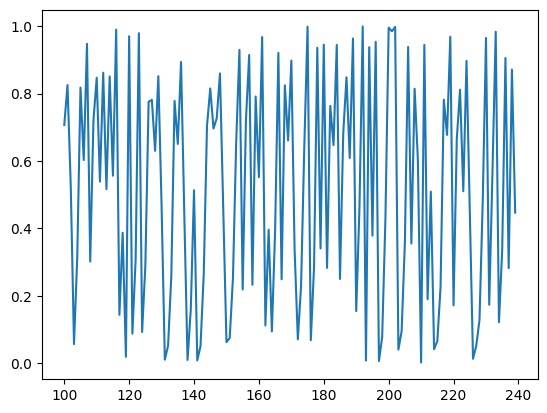

In [4]:
fig, ax = plt.subplots(ncols=1)

idx_range = range(100, 240)

ax.plot(idx_range, datasets["train"][idx_range])

#### Data preparation

In [5]:
from kkseq.data_utils import standardized_batched_context_from_time_series_list, LinearScaler
from kkseq.koopkernel_sequencer import (
    RBFKernel,
    NystroemKoopKernelSequencer,
)

First we define a list of all the trajectories (in this example there is only a single trajectory).

In [6]:
time_series_list_train = [datasets["train"]]
time_series_list_val = [datasets["valid"]]
time_series_list_test = [datasets["test"]]

Define batch size, input and output length. Each context window has size `context_length = input_length + output_length`, which always contains both the input and output context windows. The model learns to predict the output window based on the input window.

In [7]:
batch_size = 8
input_length = 6
output_length = 1
context_length = input_length + output_length
scaler = LinearScaler()

We generate standardized (scaled) and batched tensor context windows from the list of training time series. Similar, one gets the validation and test tensor-context data.

In [8]:
tensor_context_inps_train, tensor_context_tgts_train = (
    standardized_batched_context_from_time_series_list(
        time_series_list_train,
        batch_size,
        scaler,
        context_length=context_length,
        time_lag=1,
        fit=True,
        input_length=input_length,
        output_length=output_length,
    )
)
tensor_context_inps_train.shape, tensor_context_tgts_train.shape

(torch.Size([8, 124, 6, 1]), torch.Size([8, 124, 6, 1]))

#### Define the model

Set some model parameters. A more detailed description of different model variants is given below.

In [9]:
koopman_kernel_num_centers = 50
koopman_kernel_length_scale = 0.1
context_mode = "full_context"
mask_koopman_operator = True
mask_version = 1
use_nystroem_context_window = True

In [10]:
rbf = RBFKernel(length_scale=koopman_kernel_length_scale)
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)

## Architecture choices

The `NystroemKoopKernelSequencer` comes in several variants which will be briefly discussed below. The architecture variants are benchmarked against each other in `./model_training/train_koopkernel_sequencer.py` for time series coming from the chaotic Lorenz attractor. Results are plotted in `./examples/lorenz_system.ipynb`.

#### Context mode

The `context_mode` argument defines how the context window is used for prediction. Let's say our input data `(batch_size, input_length, num_feats)`. This is transformed into the kernel feature space via application of the Nystroem kernel, results in the transformed data `kernel_nysX_X` of shape `(batch_size, input_length * num_nys_centers)`.

##### `full_context`

In this mode the Koopman operator has shape `(input_length * num_nys_centers, input_length * num_nys_centers)`. One can think of the Koopman operator as a block structured matrix with `input_length` many blocks each of size `num_nys_centers`. Let's view the kernelized data (apart from its batch dimension) as `input_length` subvectors each of size `num_nys_centers`.

The Koopman operator maps the entire input window one time step ahead. Each of the `input_length` many blocks corresponds to one time step in the input window of the full context window, which is mapped (taking into account information from all the other time steps in the input window) to the next time step. In this sense, the Koopman operator acts in a similar way as the attention mechanism in transformer architectures (in this case attention scores are computed for all pairs of entries in the context window).

In [11]:
context_mode = "full_context"
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)
koopkernelmodel.global_koopman_operator.shape

torch.Size([300, 300])

The Koopman operator has shape `(input_length * num_nys_centers, input_length * num_nys_centers) = (300, 300)` for `input_length = 6` and `num_nys_centers = 60`.

##### `last_context`

In this mode the Koopman operator has shape `(num_nys_centers, input_length * num_nys_centers)`. If viewed as block structured matrix with subblock size `num_nys_centers`, it can be though off as the last row of the Koopman operator in the `full_context` mode. Note that this last row is the only relevant row for computing the next time step in the output window. The upper rows map previous time steps to following time steps within the input window.

This architecture is more efficient, reducing the number of trainable parameters. This is clearly visible in the training runtimes. However, in some test scenarios the `full_context` mode architecture achieves better RMSE scores, as it takes into account more information from the input window for the next step predictions.

In [12]:
context_mode = "last_context"
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)
koopkernelmodel.global_koopman_operator.shape

Masking has no effect for context_mode=no_context, last_context.


torch.Size([50, 300])

The Koopman operator has shape `(num_nys_centers, input_length * num_nys_centers) = (50, 300)` for `input_length = 6` and `num_nys_centers = 60`. Technically, this non-quadratic matrix is only the lowest row of the Koopman operator. However, this is a more efficient representation. The remaining rows are less relevant, since the previous entries in the input window are already known and, therefore, it is not nececssary to compute them.

#### Nystroem Context Window

By default, the Nystroem kernels, mapping between feature space (where the Koopman operator acts) and the input and output spaces of the time series, do not have an own input context window axis. This means that the Nystroem kernel acts the same on each entry in the input context window (of length `input_length`). However, with the agrument `use_nystroem_context_window` one can add this `input_length` axis to the Nystroem kernels as well, allowing them to depend on the position in the input window.

The kernel `self.kernel_nysY_Y` has shape `(num_nys_centers, num_nys_centers)` for `use_nystroem_context_window = False`, and shape `(input_length, num_nys_centers, num_nys_centers)` for `use_nystroem_context_window = False` (neglecting the additional `output_length` axis which is added for `output_length > 1` as discussed below).

In [13]:
context_mode = "full_context"
output_length = 1

tensor_context_inps_train, tensor_context_tgts_train = (
    standardized_batched_context_from_time_series_list(
        time_series_list_train,
        batch_size,
        scaler,
        context_length=context_length,
        time_lag=1,
        fit=True,
        input_length=input_length,
        output_length=output_length,
    )
)

In [14]:
use_nystroem_context_window = False
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_inps_train, tensor_context_tgts_train)

koopkernelmodel.kernel_nysY_Y.shape

torch.Size([50, 50])

In [15]:
use_nystroem_context_window = True
koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_inps_train, tensor_context_tgts_train)

koopkernelmodel.kernel_nysY_Y.shape

torch.Size([6, 50, 50])

#### Output length

##### `output_length = 1`

In this case each (batched) input and target data point has shape `(batch_size, input_length, num_feats)`. The target data is shifted from the input data one step into the future along the `intput_length` axis. The Koopman operator has shape `(input_length * num_nys_centers, input_length * num_nys_centers)` (for the mode `full_context`), mapping the entire input context window (flattened) one step ahead.

In [16]:
context_mode = "full_context"
output_length = 1

tensor_context_inps_train, tensor_context_tgts_train = (
    standardized_batched_context_from_time_series_list(
        time_series_list_train,
        batch_size,
        scaler,
        context_length=context_length,
        time_lag=1,
        fit=True,
        input_length=input_length,
        output_length=output_length,
    )
)
print(tensor_context_inps_train.shape, tensor_context_tgts_train.shape)

koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_inps_train, tensor_context_tgts_train)

torch.Size([8, 124, 6, 1]) torch.Size([8, 124, 6, 1])


In [17]:
koopkernelmodel.global_koopman_operator.shape, koopkernelmodel.kernel_nysY_Y.shape

(torch.Size([300, 300]), torch.Size([6, 50, 50]))

The Koopman operator has shape `(input_length * num_nys_centers, input_length * num_nys_centers) = (300, 300)` for `input_length = 6` and `num_nys_centers = 60`. The Y-kernel `kernel_nysY_Y` has shape `(input_length, num_nys_centers, num_nys_centers)`.

##### `output_length > 1`

In case `output_length > 1`, the input data has the same shape as before, however the target data has has an additional axis of size `output_length`, i.e. shape `(batch_size, output_length, num_feats)`. The `output_length` dimension contains for each input data (shape `(batch_size, input_length, num_feats)`) the next `output_length` many time series values.

Becaue of this, also the kernels, mapping between the input and output space into the kernelized features spaces on which the Koopman operator acts, require this additioal dimension. For example, the kernel `self.kernel_nysY_Y`, mapping from the feature space to the output space, has shape `(num_nys_centers, num_nys_centers)` for `output_length = 1`, and shape `(output_length, num_nys_centers, num_nys_centers)` for `output_length > 1`. The Koopman operator itself does not require an addiational `output_length` axis.

In [18]:
context_mode = "full_context"
output_length = 3

tensor_context_inps_train, tensor_context_tgts_train = (
    standardized_batched_context_from_time_series_list(
        time_series_list_train,
        batch_size,
        scaler,
        context_length=context_length,
        time_lag=1,
        fit=True,
        input_length=input_length,
        output_length=output_length,
    )
)
print(tensor_context_inps_train.shape, tensor_context_tgts_train.shape)

koopkernelmodel = NystroemKoopKernelSequencer(
    kernel=rbf,
    input_length=input_length,
    output_length=output_length,
    output_dim=1,
    num_nys_centers=koopman_kernel_num_centers,
    rng_seed=42,
    context_mode=context_mode,
    mask_koopman_operator=mask_koopman_operator,
    mask_version=mask_version,
    use_nystroem_context_window=use_nystroem_context_window,
)
koopkernelmodel._initialize_nystrom_data(tensor_context_inps_train, tensor_context_tgts_train)

torch.Size([8, 124, 6, 1]) torch.Size([8, 124, 6, 3, 1])


The target data `tensor_context_tgts_train` has an additional `output_length` axis of size `3`.

In [19]:
koopkernelmodel.global_koopman_operator.shape, koopkernelmodel.kernel_nysY_Y.shape

(torch.Size([300, 300]), torch.Size([6, 3, 50, 50]))

The Koopman operator has shape `(input_length * num_nys_centers, input_length * num_nys_centers) = (300, 300)` for `input_length = 6` and `num_nys_centers = 60`. The Y-kernel `kernel_nysY_Y` has shape `(input_length, output_length, num_nys_centers, num_nys_centers) = (6, 3, 50, 50)`.

## References
<a id="1">[1]</a> 
Kostic, V. et al. (2022). 
Learning Dynamical Systems via Koopman Operator Regression in Reproducing Kernel Hilbert Spaces.
arXiv:2205.14027.